# Memory locality, Rows vs. Columns

## The effect of row vs column major layout
The way you traverse a 2D array effects speed.

* [numpy arrays](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html#numpy-array) are, by default, organized in a row-major order. 

```python
a=array([range(1,31)]).reshape([3,10])
```
<img alt="" src="Figures/Row-major-layout.png" style="width:600px" />

* `a[i,j]` and `a[i,j+1]` are placed in consecutive places in memory.

* `a[i,j]` and `a[i+1,j]` are 10 memory locations apart.

* This implies that scanning the array row by row is more local than scanning column by column.

* locality implies speed.

In [5]:
%pylab inline
from time import time

# create an n by n array
n=10000
a=ones([n,n])
print(a)

Populating the interactive namespace from numpy and matplotlib
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [6]:
%%time
# Scan column by column
s=0;
for i in range(n): s+=sum(a[:,i])

CPU times: user 980 ms, sys: 8.58 ms, total: 988 ms
Wall time: 1.01 s


In [7]:
%%time
## Scan row by row
s=0;
for i in range(n): s+=sum(a[i,:])

CPU times: user 97.8 ms, sys: 2.41 ms, total: 100 ms
Wall time: 110 ms


## Some experiments with row vs column scanning
We want to see how the run time of these two code snippets varies as `n`, the size of the array, is changed.

In [8]:
def sample_run_times(T,k=10):
    """ compare the time to sum an array row by row vs column by column
        T: the sizes of the matrix, [10**e for e in T] 
        k: the number of repetitions of each experiment
    """
    all_times=[]
    for e in T:
        n=int(10**e)
        #print('\r',n)
        a=np.ones([n,n])
        times=[]

        for i in range(k):    
            t0=time()
            s=0;
            for i in range(n):
                s+=sum(a[:,i])
            t1=time()
            s=0;
            for i in range(n):
                s+=sum(a[i,:])
            t2=time()
            times.append({'row minor':t1-t0,'row major':t2-t1})
        all_times.append({'n':n,'times':times})
    return all_times


In [11]:
#example run
sample_run_times([1,4],k=1)

[{'n': 10,
  'times': [{'row minor': 6.008148193359375e-05,
    'row major': 3.3855438232421875e-05}]},
 {'n': 10000,
  'times': [{'row minor': 0.9492337703704834,
    'row major': 0.08232617378234863}]}]

### Plot the ratio between run times as function of n
Here we have small steps between consecutive values of `n` and only one measurement for each (`k=1`)

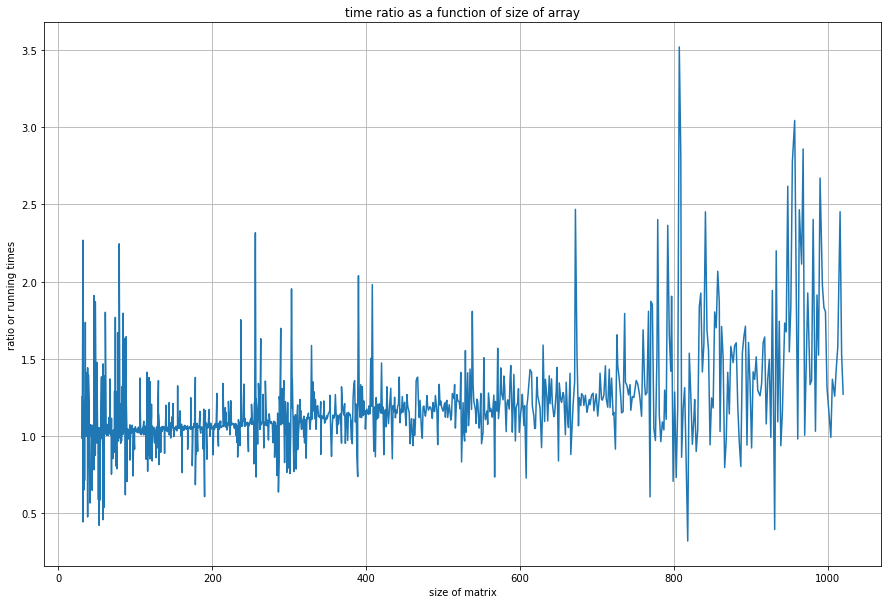

In [12]:
all_times=sample_run_times(np.arange(1.5,3.01,0.001),k=10)

n_list=[a['n'] for a in all_times]
ratios=[a['times'][0]['row minor']/a['times'][0]['row major'] for a in all_times]

figure(figsize=(15,10))
plot(n_list,ratios)
grid()
xlabel('size of matrix')
ylabel('ratio or running times')
title('time ratio as a function of size of array');

## Conclusions
* Traversing a numpy array column by column takes more than row by row.
* The effect increasese proportionally to the number of elements in the array (square of the number of rows or columns).
* Run time has large fluctuations.

* See you next time.

### Next, we want to quantify the random fluctuations
and see what is their source

In [7]:
k=100
all_times=sample_run_times(np.arange(1,3.001,0.01),k=k)
_n=[]
_row_major_mean=[]
_row_major_std=[]
_row_major_std=[]
_row_minor_mean=[]
_row_minor_std=[]
_row_minor_min=[]
_row_minor_max=[]
_row_major_min=[]
_row_major_max=[]

for times in all_times:
    _n.append(times['n'])
    row_major=[a['row major'] for a in times['times']]
    row_minor=[a['row minor'] for a in times['times']]
    _row_major_mean.append(np.mean(row_major))
    _row_major_std.append(np.std(row_major))
    _row_major_min.append(np.min(row_major))
    _row_major_max.append(np.max(row_major))

    _row_minor_mean.append(np.mean(row_minor))
    _row_minor_std.append(np.std(row_minor))
    _row_minor_min.append(np.min(row_minor))
    _row_minor_max.append(np.max(row_minor))

_row_major_mean=np.array(_row_major_mean)
_row_major_std=np.array(_row_major_std)
_row_minor_mean=np.array(_row_minor_mean)
_row_minor_std=np.array(_row_minor_std)

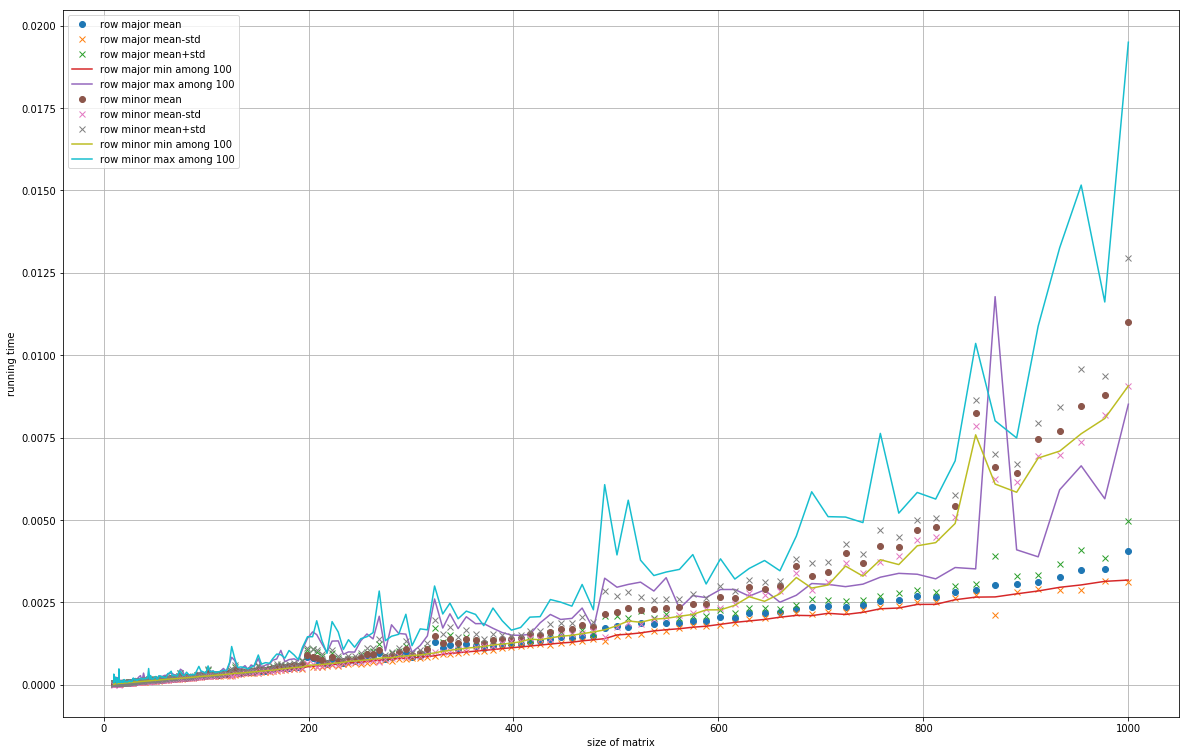

In [8]:
figure(figsize=(20,13))
plot(_n,_row_major_mean,'o',label='row major mean')
plot(_n,_row_major_mean-_row_major_std,'x',label='row major mean-std')
plot(_n,_row_major_mean+_row_major_std,'x',label='row major mean+std')
plot(_n,_row_major_min,label='row major min among %d'%k)
plot(_n,_row_major_max,label='row major max among %d'%k)
plot(_n,_row_minor_mean,'o',label='row minor mean')
plot(_n,_row_minor_mean-_row_minor_std,'x',label='row minor mean-std')
plot(_n,_row_minor_mean+_row_minor_std,'x',label='row minor mean+std')
plot(_n,_row_minor_min,label='row minor min among %d'%k)
plot(_n,_row_minor_max,label='row minor max among %d'%k)
xlabel('size of matrix')
ylabel('running time')
legend()
grid()

### Summary

1. Scan by column is slower than scan by row and the difference increases with the size.
2. scan by row increases linearly and has very little random fluctuations.
3. Scan by column increases linearly with one constant until about `n=430` and then increases with a higher constant.
4. Scan by column has large fluctatuations around the mean.